In [2]:
import Pkg
Pkg.add(url="https://github.com/lucabrugnolini/VectorAutoregressions.jl")

     Cloning git-repo `https://github.com/lucabrugnolini/VectorAutoregressions.jl`
    Updating git-repo `https://github.com/lucabrugnolini/VectorAutoregressions.jl`
    Updating registry at `C:\Users\matsz\.julia\registries\General.toml`
   Resolving package versions...
   Installed EllipsisNotation ─ v0.4.0
   Installed GrowableArrays ─── v0.1.0
    Updating `C:\Users\matsz\.julia\environments\v1.10\Project.toml`
  [dd6ac5f8] + VectorAutoregressions v0.1.0 `https://github.com/lucabrugnolini/VectorAutoregressions.jl#master`
    Updating `C:\Users\matsz\.julia\environments\v1.10\Manifest.toml`
⌅ [da5c29d0] + EllipsisNotation v0.4.0
  [7ebbc34c] + GrowableArrays v0.1.0
  [dd6ac5f8] + VectorAutoregressions v0.1.0 `https://github.com/lucabrugnolini/VectorAutoregressions.jl#master`
        Info Packages marked with ⌅ have new versions available but compatibility constraints restrict them from upgrading. To see why use `status --outdated -m`
Precompiling project...
  ✓ EllipsisNotation
  ✓ 

In [327]:
using Turing, MCMCChains
using XLSX
using DataFrames, TimeSeries
using StatsPlots
using LinearAlgebra
using VectorAutoregressions
using CSV
using Test
using MCMCChains
using StatsBase
include("utils.jl")

print_percentiles (generic function with 2 methods)

In [2]:
columns = [:Date, :short_us, :real_us, :term_us]
data_df = DataFrame(XLSX.readtable("assets_data_03.24.xlsx", "Macro_Data"; infer_eltypes=true))[2:end, columns]
dropmissing!(data_df, disallowmissing=true)
macro_data = TimeArray(data_df; timestamp = :Date)

209×3 TimeArray{Float64, 2, Date, Matrix{Float64}} 1972-01-01 to 2024-01-01
┌────────────┬────────────┬──────────────┬─────────────┐
│            │ short_us   │ real_us      │ term_us     │
├────────────┼────────────┼──────────────┼─────────────┤
│ 1972-01-01 │     0.0388 │    0.0023571 │   0.0215333 │
│ 1972-04-01 │     0.0455 │   0.00326571 │   0.0159333 │
│ 1972-07-01 │  0.0493333 │   0.00268831 │   0.0135667 │
│ 1972-10-01 │      0.053 │   0.00368448 │   0.0107333 │
│ 1973-01-01 │      0.064 │   0.00337313 │  0.00203333 │
│ 1973-04-01 │  0.0767333 │  -0.00326431 │ -0.00866667 │
│ 1973-07-01 │   0.103533 │   0.00377342 │  -0.0314667 │
│ 1973-10-01 │  0.0923667 │   5.89786e-5 │  -0.0248333 │
│     ⋮      │     ⋮      │      ⋮       │      ⋮      │
│ 2022-07-01 │  0.0282333 │  -0.00602734 │  0.00283333 │
│ 2022-10-01 │  0.0427333 │   0.00696215 │ -0.00443333 │
│ 2023-01-01 │  0.0475333 │   0.00141827 │  -0.0110667 │
│ 2023-04-01 │  0.0513333 │  0.000898898 │     -0.0154 │
│ 2023-07-01

In [3]:
data_df = DataFrame(XLSX.readtable("assets_data_03.24.xlsx", "Indexes"; infer_eltypes=true))[1:end, [:Date, :USA_Net]]
dropmissing!(data_df, disallowmissing=true)
data = TimeArray(data_df; timestamp = :Date)
data = collapse(data, Dates.quarter, last)

dates = timestamp(data) .+ Day(1)

data = TimeArray(data; timestamp = dates)

equity = percentchange(data, :log)

205×1 TimeArray{Float64, 1, Date, Vector{Float64}} 1973-04-01 to 2024-04-01
┌────────────┬────────────┐
│            │ USA_Net    │
├────────────┼────────────┤
│ 1973-04-01 │ -0.0833335 │
│ 1973-07-01 │ -0.0532413 │
│ 1973-10-01 │  0.0402782 │
│ 1974-01-01 │ -0.0900348 │
│ 1974-04-01 │ -0.0428685 │
│ 1974-07-01 │ -0.0874197 │
│ 1974-10-01 │  -0.301121 │
│ 1975-01-01 │  0.0939096 │
│     ⋮      │     ⋮      │
│ 2022-10-01 │ -0.0493364 │
│ 2023-01-01 │  0.0674734 │
│ 2023-04-01 │  0.0731963 │
│ 2023-07-01 │  0.0824719 │
│ 2023-10-01 │ -0.0322941 │
│ 2024-01-01 │   0.111622 │
│ 2024-04-01 │  0.0979943 │
└────────────┴────────────┘
           190 rows omitted

In [4]:
mean(equity) .* 4

1×1 TimeArray{Float64, 1, Date, Vector{Float64}} 2024-04-01 to 2024-04-01
┌────────────┬───────────┐
│            │ USA_Net   │
├────────────┼───────────┤
│ 2024-04-01 │ 0.0917981 │
└────────────┴───────────┘

In [5]:
e_premium = equity .- macro_data[:short_us] ./ 4

204×1 TimeArray{Float64, 1, Date, Vector{Float64}} 1973-04-01 to 2024-01-01
┌────────────┬──────────────────┐
│            │ USA_Net_short_us │
├────────────┼──────────────────┤
│ 1973-04-01 │        -0.102517 │
│ 1973-07-01 │       -0.0791246 │
│ 1973-10-01 │        0.0171865 │
│ 1974-01-01 │        -0.111635 │
│ 1974-04-01 │       -0.0702268 │
│ 1974-07-01 │        -0.117486 │
│ 1974-10-01 │        -0.324538 │
│ 1975-01-01 │        0.0771846 │
│     ⋮      │        ⋮         │
│ 2022-07-01 │         -0.19188 │
│ 2022-10-01 │       -0.0600197 │
│ 2023-01-01 │          0.05559 │
│ 2023-04-01 │         0.060363 │
│ 2023-07-01 │        0.0689052 │
│ 2023-10-01 │       -0.0457858 │
│ 2024-01-01 │        0.0984798 │
└────────────┴──────────────────┘
                 189 rows omitted

In [6]:
mean(e_premium) .* 4

1×1 TimeArray{Float64, 1, Date, Vector{Float64}} 2024-01-01 to 2024-01-01
┌────────────┬──────────────────┐
│            │ USA_Net_short_us │
├────────────┼──────────────────┤
│ 2024-01-01 │        0.0403383 │
└────────────┴──────────────────┘

In [245]:
returns = merge(macro_data, e_premium)
returns = from(returns,Date(2001,01,01))

93×4 TimeArray{Float64, 2, Date, Matrix{Float64}} 2001-01-01 to 2024-01-01
┌────────────┬────────────┬──────────────┬─────────────┬──────────────────┐
│            │ short_us   │ real_us      │ term_us     │ USA_Net_short_us │
├────────────┼────────────┼──────────────┼─────────────┼──────────────────┤
│ 2001-01-01 │  0.0525667 │    0.0035248 │ -0.00206667 │        -0.104978 │
│ 2001-04-01 │  0.0409667 │ -0.000190774 │   0.0117333 │        -0.134756 │
│ 2001-07-01 │  0.0333667 │   0.00699366 │   0.0164333 │        0.0486147 │
│ 2001-10-01 │  0.0205667 │   0.00794511 │   0.0271333 │        -0.163848 │
│ 2002-01-01 │  0.0182333 │  0.000981528 │   0.0325333 │        0.0894104 │
│ 2002-04-01 │  0.0183333 │  -0.00623603 │   0.0326667 │      -0.00294185 │
│ 2002-07-01 │     0.0176 │  0.000136223 │       0.025 │         -0.15933 │
│ 2002-10-01 │  0.0148667 │  0.000577035 │      0.0252 │        -0.194578 │
│     ⋮      │     ⋮      │      ⋮       │      ⋮      │        ⋮         │
│ 2022-07-01 

In [246]:
returns_summarystats(returns,1)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
short_us,0.0179252,0.0542667,0.0182909,0.0281667,0.001,0.864191,0.0028,0.924141,-0.6098,1.0204,0.0124
real_us,0.00855531,0.0357101,-0.00166775,0.00257951,-0.0258859,0.507831,-0.00592342,0.386691,3.78181,-0.194937,-0.00145162
term_us,0.0128375,0.0351,0.0130611,0.0245333,-0.0154,-0.231816,0.00436667,0.906489,-0.83616,1.01741,0.0139667
USA_Net_short_us,0.0881671,0.195054,0.0116429,0.0628028,-0.256353,-0.896384,-0.0299651,0.0513315,0.622257,0.132055,0.0259483


In [9]:
CSV.write("usa.csv",returns)

"usa.csv"

In [219]:
model = VAR(values(returns), 1, true)

VAR([0.0767333333333333 -0.0032643068090423034 -0.0086666666666666 -0.10251684479395795; 0.10353333333333299 0.003773416161491721 -0.031466666666666296 -0.07912463252540157; … ; 0.0539666666666666 0.012356876445824887 -0.009566666666666598 -0.045785771432493155; 0.052566666666666595 0.002684271890795644 -0.010966666666666597 0.09847984128758931], [0.10353333333333299 0.0923666666666666 … 0.0539666666666666 0.052566666666666595; 0.003773416161491721 5.897855263142099e-5 … 0.012356876445824887 0.002684271890795644; -0.031466666666666296 -0.02483333333333329 … -0.009566666666666598 -0.010966666666666597; -0.07912463252540157 0.017186488034891395 … -0.045785771432493155 0.09847984128758931], [1.0 1.0 … 1.0 1.0; 0.0767333333333333 0.10353333333333299 … 0.054266666666666595 0.0539666666666666; … ; -0.0086666666666666 -0.031466666666666296 … -0.012766666666666593 -0.009566666666666598; -0.10251684479395795 -0.07912463252540157 … 0.06890518427257061 -0.045785771432493155], [-0.0010656671197905

In [220]:
round.(model.β, digits=6)

4×5 Matrix{Float64}:
 -0.001066   1.01681   -0.229077  0.057198   0.015635
 -0.004058   0.09257    0.450456  0.090799   0.003039
  0.001739  -0.01772    0.128329  0.889771  -0.011675
  0.015426  -0.283758   0.77338   0.702965   0.034438

In [221]:
round.(model.Σ, digits=4)

4×4 Matrix{Float64}:
  0.0001   0.0  -0.0001   0.0001
  0.0      0.0  -0.0     -0.0
 -0.0001  -0.0   0.0001  -0.0
  0.0001  -0.0  -0.0      0.0071

In [13]:
A = [1 2; 3 4]


2×2 Matrix{Int64}:
 1  2
 3  4

In [14]:
B = [1 2; 3 4]

2×2 Matrix{Int64}:
 1  2
 3  4

In [15]:
A * B

2×2 Matrix{Int64}:
  7  10
 15  22

In [16]:
dot(A,B)

30

In [17]:
kron(A,B)

4×4 Matrix{Int64}:
 1   2   2   4
 3   4   6   8
 3   6   4   8
 9  12  12  16

- [ ] Normal Wishart Prior gibs sampler
- [ ] draw posterior parameters
- [ ] describe posterior parameters
- [ ] simulate
- [ ] plot simulation
- [ ] estimate momoments estimation
- [ ] calculate waic i inne miary

In [18]:
test_data = values(returns)[154:end,:]

51×4 Matrix{Float64}:
 0.00286667  -0.00336044    0.0214      -3.20364e-5
 0.00423333   0.00257951    0.0162333   -0.153821
 0.0033      -0.00710024    0.0170667    0.108295
 0.003       -0.00749158    0.0152333    0.118372
 0.00266667  -0.00152444    0.0137667   -0.0329988
 0.00233333   0.000222809   0.0147333    0.0596389
 0.0022      -0.00533607    0.0173      -0.00491949
 0.00196667  -0.00490369    0.018        0.099248
 0.00123333  -0.00346436    0.0258667    0.0251424
 0.00126667   0.00311116    0.0262       0.0540249
 ⋮                                      
 0.00443333  -0.0214703     0.0149667    0.0939515
 0.0137      -0.0258859     0.0156      -0.05795
 0.0282333   -0.00602734    0.00283333  -0.19188
 0.0427333    0.00696215   -0.00443333  -0.0600197
 0.0475333    0.00141827   -0.0110667    0.05559
 0.0513333    0.000898898  -0.0154       0.060363
 0.0542667    0.00484838   -0.0127667    0.0689052
 0.0539667    0.0123569    -0.00956667  -0.0457858
 0.0525667    0.00268427   -

In [217]:
model = VAR(test_data, 1, true)
C_OLS = round.(model.β, digits=4)

4×5 Matrix{Float64}:
 -0.0048   1.2238  -0.2986   0.2416  -0.0187
 -0.0095   0.3539   0.3877   0.308    0.0039
  0.0054  -0.2329   0.1603   0.7074   0.0179
  0.1055  -2.8488   2.556   -3.155   -0.1553

In [218]:
round.(model.Σ,digits=4)

4×4 Matrix{Float64}:
  0.0  -0.0     -0.0   0.0
 -0.0   0.0     -0.0  -0.0002
 -0.0  -0.0      0.0   0.0
  0.0  -0.0002   0.0   0.0061

In [187]:
sqrt.(diag(model.Σ))

4-element Vector{Float64}:
 0.0030705001687552605
 0.006538782935222306
 0.002766739441597141
 0.07834819743756467

## Normal Wishart Prior gibs sampler
- [x] draw covariance matrix
- [] draw coeff - zrobić, aby działało
- refactor, to ols model, i NormalWishartBVAR
- zrobić testy

In [275]:
include("financial_bvar_temp.jl")

model = FinancialBVAR.NormalWishartBVAR(test_data)

round.(transpose(model.C_OLS), digits=4)


4×5 Matrix{Float64}:
 -0.0048   1.2238  -0.2986   0.2416  -0.0187
 -0.0095   0.3539   0.3877   0.308    0.0039
  0.0054  -0.2329   0.1603   0.7074   0.0179
  0.1055  -2.8488   2.556   -3.155   -0.1553

ErrorException: type NormalWishartBVARmodel has no field var_names

In [191]:
round.(model.S_OLS,digits=4)

4×4 Matrix{Float64}:
  0.0004  -0.0001  -0.0001   0.0003
 -0.0001   0.0019  -0.0001  -0.0085
 -0.0001  -0.0001   0.0003   0.0015
  0.0003  -0.0085   0.0015   0.2762

In [177]:
sqrt.(diag(model.S_OLS))

4-element Vector{Float64}:
 0.020597541306784012
 0.04386348939981804
 0.018559852402323048
 0.5255756861549084

In [195]:
FinancialBVAR.sample_posterior!(model, 10000,200)
sig = median(model.Σ[:,:,:],dims=1)

1×4×4 Array{Float64, 3}:
[:, :, 1] =
 1.00346e-5  -3.1917e-6  -3.07893e-6  7.74163e-6

[:, :, 2] =
 -3.1917e-6  4.56391e-5  -2.71833e-6  -0.000199086

[:, :, 3] =
 -3.07893e-6  -2.71833e-6  8.1355e-6  3.40674e-5

[:, :, 4] =
 7.74163e-6  -0.000199086  3.40674e-5  0.00650492

In [197]:
sig[1,4,4]

0.08065308067844786

In [198]:
model.Β

10000×20 Matrix{Float64}:
 -0.00501786   1.23208  -0.363538  …  1.49239   -3.74753   -0.25976
  0.000366239  1.00121  -0.261205     1.82823   -0.436804  -0.124361
 -0.0026446    1.16478  -0.375285     3.05868   -3.58505   -0.29954
 -0.00592592   1.27294  -0.291447     4.08579   -2.28664   -0.0275396
 -0.00640821   1.24066  -0.241858     2.21959   -7.54504    0.0599304
 -0.00368009   1.20195  -0.387988  …  3.58463   -7.31715    0.0905637
 -0.00575033   1.27873  -0.300019     4.02362   -5.13639   -0.129687
 -0.00339941   1.17906  -0.339631     3.19074    2.31386   -0.18309
 -0.00249741   1.15154  -0.262947     2.92736   -7.16208   -0.22125
 -0.0059767    1.2781   -0.380921     0.45693   -4.29874   -0.0806245
  ⋮                                ⋱                       
 -0.00340776   1.14478  -0.258841     2.84273   -4.42947   -0.315362
 -0.00257922   1.15393  -0.326732     0.692955  -0.424599  -0.253015
 -0.00631242   1.24192  -0.236529     3.24809   -0.869123  -0.286272
 -0.00496186   1.

In [199]:
describe(model.Β[:,20])

Summary Stats:
Length:         10000
Missing Count:  0
Mean:           -0.154953
Std. Deviation: 0.154085
Minimum:        -0.852062
1st Quartile:   -0.254920
Median:         -0.153688
3rd Quartile:   -0.054578
Maximum:        0.491530
Type:           Float64


In [200]:
mean(model.Β,dims=1)

1×20 Matrix{Float64}:
 -0.0047658  1.2234  -0.298723  0.241311  …  2.54925  -3.16988  -0.154953

In [201]:
chn = Chains(model.Β)

Chains MCMC chain (10000×20×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
parameters        = param_1, param_2, param_3, param_4, param_5, param_6, param_7, param_8, param_9, param_10, param_11, param_12, param_13, param_14, param_15, param_16, param_17, param_18, param_19, param_20

Summary Statistics
  parameters      mean       std      mcse     ess_bulk     ess_tail      rhat ⋯
      Symbol   Float64   Float64   Float64      Float64      Float64   Float64 ⋯

     param_1   -0.0048    0.0018    0.0000    9757.9197    9271.8137    1.0000 ⋯
     param_2    1.2234    0.0638    0.0007    9502.1589    9663.5041    1.0000 ⋯
     param_3   -0.2987    0.0654    0.0007   10007.4408    9735.9115    1.0001 ⋯
     param_4    0.2413    0.0908    0.0009    9855.0263    9243.9661    1.0000 ⋯
     param_5   -0.0188    0.0060    0.0001    9441.0083   10084.0495    1.0001 ⋯
     param_6   -0.0095    0.0038    0.0000   10116.3614    9994.2855    1

In [202]:
summarize(chn)


  parameters      mean       std      mcse     ess_bulk     ess_tail      rhat ⋯
      Symbol   Float64   Float64   Float64      Float64      Float64   Float64 ⋯

     param_1   -0.0048    0.0018    0.0000    9757.9197    9271.8137    1.0000 ⋯
     param_2    1.2234    0.0638    0.0007    9502.1589    9663.5041    1.0000 ⋯
     param_3   -0.2987    0.0654    0.0007   10007.4408    9735.9115    1.0001 ⋯
     param_4    0.2413    0.0908    0.0009    9855.0263    9243.9661    1.0000 ⋯
     param_5   -0.0188    0.0060    0.0001    9441.0083   10084.0495    1.0001 ⋯
     param_6   -0.0095    0.0038    0.0000   10116.3614    9994.2855    1.0003 ⋯
     param_7    0.3563    0.1350    0.0014    9963.7799    9564.8268    1.0003 ⋯
     param_8    0.3865    0.1364    0.0014    9902.3452    9879.1071    1.0000 ⋯
     param_9    0.3103    0.1933    0.0019   10119.9372   10045.6973    1.0004 ⋯
    param_10    0.0039    0.0128    0.0001    9719.8261    9681.7996    1.0002 ⋯
    param_11    0.0054    

In [294]:
include("financial_bvar_temp.jl")
model = FinancialBVAR.VARModel(returns)

Main.FinancialBVAR.VARModel([:short_us, :real_us, :term_us, :USA_Net_short_us], [0.0409666666666667 -0.00019077443834916545 0.011733333333333297 -0.13475568964260207; 0.0333666666666667 0.006993656194853087 0.016433333333333307 0.048614696815476824; … ; 0.0539666666666666 0.012356876445824887 -0.009566666666666598 -0.045785771432493155; 0.052566666666666595 0.002684271890795644 -0.010966666666666597 0.09847984128758931], [1.0 0.052566666666666595 … -0.0020666666666665987 -0.10497767990159339; 1.0 0.0409666666666667 … 0.011733333333333297 -0.13475568964260207; … ; 1.0 0.054266666666666595 … -0.012766666666666593 0.06890518427257061; 1.0 0.0539666666666666 … -0.009566666666666598 -0.045785771432493155], [-0.0008854440861314199 -0.006720827359695345 0.00250947177703575 0.05583633625120618; 1.0223875688732265 0.2341331207780678 -0.06827162893923651 -1.5645122040394892; … ; 0.0017401438920247258 0.08844653893618519 0.925062210743995 -1.1193910072272542; -0.00208488937546617 -0.0002399475516

In [285]:
model.Y

92×4 Matrix{Float64}:
 0.0409667   -0.000190774   0.0117333   -0.134756
 0.0333667    0.00699366    0.0164333    0.0486147
 0.0205667    0.00794511    0.0271333   -0.163848
 0.0182333    0.000981528   0.0325333    0.0894104
 0.0183333   -0.00623603    0.0326667   -0.00294185
 0.0176       0.000136223   0.025       -0.15933
 0.0148667    0.000577035   0.0252      -0.194578
 0.0126333   -0.00691543    0.0265667    0.0784748
 0.0116667   -0.00072394    0.0245333   -0.0348314
 0.0107      -0.00221679    0.0316333    0.14083
 ⋮                                      
 0.00443333  -0.0214703     0.0149667    0.0939515
 0.0137      -0.0258859     0.0156      -0.05795
 0.0282333   -0.00602734    0.00283333  -0.19188
 0.0427333    0.00696215   -0.00443333  -0.0600197
 0.0475333    0.00141827   -0.0110667    0.05559
 0.0513333    0.000898898  -0.0154       0.060363
 0.0542667    0.00484838   -0.0127667    0.0689052
 0.0539667    0.0123569    -0.00956667  -0.0457858
 0.0525667    0.00268427   -0.01

In [286]:
transpose(model.C)

4×5 transpose(::Matrix{Float64}) with eltype Float64:
 -0.000885444   1.02239    -0.281869    0.00174014  -0.00208489
 -0.00672083    0.234133    0.218286    0.0884465   -0.000239948
  0.00250947   -0.0682716   0.224493    0.925062     4.30453e-5
  0.0558363    -1.56451     0.0634388  -1.11939      0.0120801

In [287]:
model.Σ

4×4 Matrix{Float64}:
  1.90776e-5   1.65671e-7   -1.30245e-5   9.49197e-5
  1.65671e-7   5.49846e-5   -9.48881e-6  -0.000116018
 -1.30245e-5  -9.48881e-6    1.93461e-5  -2.15773e-5
  9.49197e-5  -0.000116018  -2.15773e-5   0.00756942

In [288]:
model.var_names

4-element Vector{Symbol}:
 :short_us
 :real_us
 :term_us
 :USA_Net_short_us

In [293]:
model_summary(model)

In [251]:
sqrt(0.0076)

0.08717797887081347

In [354]:
(inv(Matrix(I,4,4) .- model.C[2:end,:]) * model.C[1,:]) * 1

4-element Vector{Float64}:
 -1.5257129655219652
  0.43881908663966346
 -0.3745387301812085
  0.059616027921599285

### simulate var

- simulate from modellast data
- simulate from given data


In [320]:
include("financial_bvar_temp.jl")

simulations = FinancialBVAR.simulate(model,60,20000)

4×20000×61 Array{Float64, 3}:
[:, :, 1] =
  0.0525667    0.0525667    0.0525667   …   0.0525667    0.0525667
  0.00268427   0.00268427   0.00268427      0.00268427   0.00268427
 -0.0109667   -0.0109667   -0.0109667      -0.0109667   -0.0109667
  0.0984798    0.0984798    0.0984798       0.0984798    0.0984798

[:, :, 2] =
  0.0495933     0.0562181   0.0627617   …   0.0528499    0.053664
  0.00122924    0.0102005   0.00895581     -0.00156987   0.00143451
 -0.010671     -0.0133803  -0.0198624      -0.00820687  -0.0187888
  0.000131682  -0.0469665   0.0968383      -0.00931134  -0.0025386

[:, :, 3] =
  0.0429039    0.0556426   0.0597069   0.0613736  …   0.0568174    0.0515575
  0.00653447   0.0142516   0.014515    0.016864       0.00575069  -0.00602016
 -0.00972581  -0.0163385  -0.0159144  -0.0101941     -0.0146105   -0.0127182
 -0.107163    -0.081275    0.146328   -0.06018       -0.0570889   -0.0447608

;;; … 

[:, :, 59] =
  0.0154632   0.00735681  0.00688458  0.0139061   …   0.0200483 

In [253]:
names = ["short_us", "real_us", "term_us", "USA_Net_short_us"]
for i in 1:4    
    print_percentiles(simulations[i,:,:],[.05, .25,  .5, .75, .95], names[i]) 
end

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61
0.05,0.0525667,0.0447049,0.0398524,0.0356318,0.0322307,0.0289583,0.0264688,0.0241099,0.021959,0.0198865,0.0180869,0.0163804,0.0148128,0.0133391,0.0118772,0.0106723,0.00931884,0.00844592,0.00734043,0.00642411,0.00553335,0.00440738,0.00341504,0.00286417,0.00179864,0.00106454,0.000546755,-5.83758e-5,-0.000753257,-0.00133226,-0.00197624,-0.00216275,-0.00297652,-0.00336282,-0.00401338,-0.00406261,-0.00447845,-0.00505182,-0.00523857,-0.00593618,-0.00604205,-0.00656195,-0.00683038,-0.00684357,-0.0067823,-0.00691161,-0.00716397,-0.00733901,-0.00747455,-0.00771043,-0.00801396,-0.00839705,-0.00871873,-0.00907368,-0.00932747,-0.00957027,-0.00935938,-0.00977827,-0.00992141,-0.0101021,-0.0102684
0.25,0.0525667,0.0488857,0.0462426,0.0437926,0.0414234,0.0394435,0.0377153,0.0359732,0.0343796,0.0329314,0.0316579,0.0303108,0.0292068,0.0281648,0.0271348,0.0260716,0.0250785,0.0241216,0.0232537,0.0224575,0.021727,0.0208445,0.0199314,0.0194027,0.0187782,0.0179466,0.0172512,0.0167963,0.0164292,0.0158914,0.0154018,0.0149588,0.0144296,0.013985,0.0137038,0.0132107,0.0129537,0.0125905,0.0122044,0.0119986,0.0117053,0.0114561,0.0111829,0.0108179,0.0106179,0.0104516,0.010255,0.0100422,0.00984332,0.00981756,0.00953683,0.0093221,0.00915893,0.00894194,0.00873685,0.00868095,0.00863441,0.00837761,0.00839538,0.00823668,0.00836944
0.5,0.0525667,0.0518508,0.0506292,0.0493562,0.0481496,0.0468767,0.045445,0.0443061,0.0431692,0.0420188,0.0409728,0.0401598,0.0392041,0.0384428,0.0375214,0.0365775,0.0357549,0.0349935,0.034082,0.0333668,0.0327686,0.0321981,0.0317096,0.0311088,0.0305433,0.0300581,0.0295045,0.0289626,0.0284555,0.0277662,0.0273043,0.0269557,0.0265306,0.0262368,0.0259797,0.025611,0.0252068,0.0247117,0.0245262,0.0240707,0.0238128,0.0236218,0.0234634,0.0232356,0.0229242,0.0227583,0.0228228,0.0225866,0.022292,0.0221559,0.0219566,0.0217683,0.0214701,0.0213992,0.0213336,0.0212211,0.0209738,0.0208924,0.0207679,0.0205856,0.0206116
0.75,0.0525667,0.0547991,0.0550945,0.0549458,0.0545746,0.0540176,0.0533172,0.0526515,0.0518637,0.0512202,0.050755,0.0499757,0.0494426,0.0487512,0.0480636,0.0474635,0.0468089,0.0460483,0.0454662,0.0449465,0.044278,0.0436722,0.043209,0.0427156,0.0424557,0.0418283,0.041371,0.0408305,0.0403607,0.0399375,0.0397456,0.03938,0.0388846,0.0384649,0.0380942,0.0379513,0.0375443,0.0372685,0.0369614,0.036716,0.0363113,0.036165,0.0357876,0.0355484,0.0353561,0.035057,0.0350103,0.0349112,0.0348348,0.0348111,0.0344576,0.0341223,0.0340885,0.0338358,0.0335901,0.0333656,0.0333007,0.0333033,0.0330996,0.0330122,0.0331374
0.95,0.0525667,0.0590797,0.0614615,0.0630055,0.0638605,0.0643411,0.0646987,0.0648299,0.0645563,0.0644159,0.0643893,0.064143,0.0639655,0.0636497,0.0631288,0.0626279,0.0624518,0.0620323,0.0616314,0.0610536,0.0609634,0.0604339,0.0602271,0.0596524,0.0595316,0.0593284,0.0586955,0.0582307,0.0575918,0.0572855,0.0569491,0.0564291,0.0562099,0.0559249,0.0556785,0.0552615,0.0549985,0.0549137,0.0547392,0.0548169,0.0544056,0.0541725,0.0539078,0.0537427,0.0534111,0.0533048,0.0530246,0.0527619,0.052538,0.0524401,0.0522191,0.0523881,0.0521928,0.0519444,0.0517381,0.0515317,0.0514328,0.0513123,0.0511521,0.050821,0.0508749


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61
0.05,0.00268427,-0.00689885,-0.00686464,-0.00697428,-0.00742706,-0.00760926,-0.00818492,-0.00873985,-0.00898809,-0.0094356,-0.00975161,-0.00999457,-0.0100978,-0.0107937,-0.0109971,-0.0109344,-0.0112386,-0.0114193,-0.011651,-0.0119772,-0.0121519,-0.0123805,-0.0124825,-0.0124297,-0.0129829,-0.012865,-0.0133849,-0.0131137,-0.0134116,-0.013554,-0.0136687,-0.0134454,-0.0136373,-0.013978,-0.0140114,-0.0140906,-0.0142028,-0.0143915,-0.0142881,-0.0144441,-0.0147083,-0.0146084,-0.0147196,-0.0148112,-0.0148284,-0.0146472,-0.0148687,-0.0148377,-0.0148718,-0.0148994,-0.0150372,-0.0150265,-0.0150135,-0.0151944,-0.0150814,-0.0154272,-0.0153415,-0.0153065,-0.0154894,-0.0154302,-0.0153529
0.25,0.00268427,0.000204644,0.000432224,0.00025548,0.000111289,-0.000228513,-0.000426888,-0.000785357,-0.00126455,-0.00161583,-0.00179596,-0.00208546,-0.00227784,-0.00262195,-0.00273366,-0.00292822,-0.00314393,-0.00318014,-0.00352411,-0.00386112,-0.00393713,-0.00403515,-0.00421541,-0.00438861,-0.00446827,-0.00454704,-0.00490024,-0.0048154,-0.00506605,-0.00520908,-0.00527472,-0.00521205,-0.00547499,-0.00575057,-0.00579827,-0.00575038,-0.00585822,-0.00581777,-0.00593559,-0.00615343,-0.00625243,-0.00613466,-0.00624105,-0.00639114,-0.00652433,-0.0064637,-0.00644376,-0.00668717,-0.00671174,-0.00658038,-0.00650311,-0.0066617,-0.00666141,-0.00677074,-0.0068987,-0.00698269,-0.00695685,-0.00707647,-0.00708415,-0.00711629,-0.00704728
0.5,0.00268427,0.00515812,0.00562688,0.0054967,0.00522478,0.00501715,0.00479478,0.00450421,0.0041543,0.0038549,0.00368788,0.00341461,0.00327795,0.00309045,0.00295952,0.00275384,0.00254702,0.00231678,0.00213212,0.00192927,0.00176632,0.0016622,0.00140317,0.00142809,0.00130068,0.00118239,0.000963002,0.000914267,0.000652481,0.000621566,0.000429529,0.000548865,0.000302414,0.00012797,-9.77424e-7,0.000111795,7.09245e-6,2.28953e-5,-0.000112444,-0.00031217,-0.000252027,-0.000368701,-0.000514547,-0.000575312,-0.000647381,-0.000658246,-0.000591212,-0.00079187,-0.000810477,-0.00067204,-0.000751538,-0.000881483,-0.00077403,-0.000911961,-0.000999585,-0.00118712,-0.00105102,-0.000960985,-0.00126519,-0.00132221,-0.00118033
0.75,0.00268427,0.0101005,0.0107738,0.0106133,0.0105344,0.0103254,0.0100609,0.00992496,0.00957918,0.00935531,0.00920369,0.00890379,0.00874101,0.00868024,0.00842334,0.00848673,0.00813103,0.00798275,0.007828,0.00749587,0.00747253,0.00737151,0.00711244,0.00706112,0.00706977,0.00685748,0.00681496,0.00663228,0.00653069,0.00639481,0.00629,0.00631212,0.00608905,0.00588578,0.00584674,0.00611544,0.00574546,0.00578075,0.00571964,0.00564627,0.0055391,0.00541744,0.00537581,0.00525247,0.00525206,0.00508671,0.00532012,0.00506937,0.00514036,0.00510983,0.00509215,0.00493879,0.00511793,0.00491426,0.00480979,0.00477914,0.00486723,0.00488677,0.00457629,0.00457338,0.00481135
0.95,0.00268427,0.0174694,0.0180236,0.0181267,0.0181428,0.0179827,0.0177594,0.0176289,0.0173765,0.0171777,0.0169704,0.0169689,0.0167893,0.0167306,0.0163961,0.016472,0.0162853,0.0162257,0.0160101,0.0158442,0.01588,0.0157325,0.0156082,0.0152953,0.0154469,0.0150893,0.0152632,0.0150412,0.0149639,0.0148033,0.0146562,0.0145613,0.0144883,0.0142503,0.0143191,0.0145356,0.0142777,0.0142307,0.0140745,0.0139683,0.01381,0.0137948,0.0138004,0.0136755,0.0138514,0.0134951,0.0134286,0.013443,0.0133946,0.0135108,0.0133994,0.0134038,0.0131867,0.0131445,0.0131232,0.0132412,0.0133148,0.0131653,0.0131273,0.0131007,0.0130405


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61
0.05,-0.0109667,-0.017885,-0.0197216,-0.020784,-0.0214659,-0.0216818,-0.0218097,-0.0218162,-0.0219462,-0.0217317,-0.0214193,-0.0213014,-0.0211477,-0.0210843,-0.0208288,-0.0202771,-0.0199708,-0.0195732,-0.0194298,-0.0193464,-0.0188849,-0.0187293,-0.0183737,-0.0182065,-0.018113,-0.0177994,-0.0174847,-0.0173436,-0.0170042,-0.0167754,-0.0164274,-0.0161327,-0.0162765,-0.015982,-0.0158217,-0.0154212,-0.0153791,-0.015428,-0.0151739,-0.0150004,-0.0146807,-0.0147007,-0.0147025,-0.0144891,-0.0145993,-0.0142563,-0.0143937,-0.0142408,-0.0139848,-0.0141014,-0.0138937,-0.0138924,-0.013674,-0.0137375,-0.0134227,-0.0134361,-0.013456,-0.0134373,-0.0132391,-0.0131871,-0.0134306
0.25,-0.0109667,-0.0135714,-0.0137139,-0.0135207,-0.0131497,-0.0127735,-0.0122765,-0.0118542,-0.011319,-0.0108825,-0.0104091,-0.00989808,-0.0094246,-0.00898325,-0.00855683,-0.00802945,-0.00749486,-0.00705908,-0.00660727,-0.00634187,-0.0059715,-0.00560995,-0.00534013,-0.00487474,-0.0046444,-0.00432037,-0.00403402,-0.00373548,-0.00333157,-0.00309917,-0.00291221,-0.00259518,-0.00231287,-0.00224235,-0.0018453,-0.0017658,-0.00143917,-0.0013386,-0.00121365,-0.0011204,-0.00101126,-0.000831737,-0.00069443,-0.000447915,-0.000292111,-0.000249747,-0.000243764,-0.000157906,-7.44303e-5,-2.51493e-5,0.000176562,0.000316733,0.000379957,0.000511537,0.00050782,0.000742416,0.000742621,0.000723806,0.000758773,0.000674431,0.000762599
0.5,-0.0109667,-0.0105866,-0.00962441,-0.00857994,-0.00754477,-0.00669682,-0.00569593,-0.00495436,-0.00408429,-0.00321788,-0.00254419,-0.00196462,-0.00132788,-0.000691517,-1.76315e-5,0.000578823,0.00115199,0.00159895,0.00210305,0.00258788,0.0030484,0.00362401,0.00395543,0.00421773,0.00465612,0.00503747,0.00533912,0.00577595,0.00618656,0.00650254,0.00674048,0.00677094,0.00722176,0.00740165,0.00762777,0.00778302,0.00788264,0.00813872,0.00827921,0.00849135,0.00872627,0.0087715,0.00888511,0.00899588,0.00922073,0.00930616,0.0093746,0.00958338,0.00966811,0.00962219,0.00978197,0.00999326,0.0101399,0.01017,0.010241,0.010245,0.0101792,0.0103011,0.0103443,0.010468,0.0104437
0.75,-0.0109667,-0.00763419,-0.00563288,-0.00371031,-0.00207739,-0.000590846,0.000884408,0.00213927,0.00322877,0.00423855,0.00529909,0.00609315,0.00698638,0.00770506,0.00856549,0.00917068,0.00982706,0.0105499,0.0110983,0.0117222,0.0121448,0.0125712,0.0131332,0.01362,0.0139757,0.0144809,0.0149037,0.0152911,0.0155278,0.0157975,0.016085,0.0163838,0.016752,0.0169668,0.0171747,0.0174646,0.0175723,0.017653,0.0179123,0.0179824,0.018188,0.0185998,0.0186984,0.0186638,0.0189132,0.0190912,0.0190379,0.019151,0.0191247,0.0193491,0.0194899,0.0196366,0.0197297,0.0199381,0.0199707,0.0200181,0.019901,0.0200004,0.0201481,0.0201919,0.0201192
0.95,-0.0109667,-0.00336207,0.000337521,0.00326164,0.00576874,0.00818474,0.0104997,0.0123047,0.0139337,0.0156756,0.016879,0.0179408,0.0191294,0.0199665,0.0208713,0.0216661,0.0224505,0.0232714,0.0238039,0.0245683,0.0252223,0.0259655,0.0264385,0.0269654,0.0275329,0.0279088,0.0282917,0.0285045,0.0290151,0.0293915,0.029764,0.0299455,0.0299911,0.0306044,0.031004,0.0309312,0.0314202,0.0314443,0.0319189,0.0321033,0.0320813,0.0321864,0.0324408,0.0325419,0.0325666,0.0326166,0.0329226,0.0329567,0.0331528,0.0331729,0.033361,0.0333129,0.0335457,0.0338858,0.0339277,0.0339904,0.0340851,0.0343404,0.0343924,0.0344226,0.0346862


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61
0.05,0.0984798,-0.154379,-0.157238,-0.15543,-0.15604,-0.155633,-0.154114,-0.15378,-0.154373,-0.152288,-0.150106,-0.150435,-0.149779,-0.149125,-0.152203,-0.14724,-0.150617,-0.146142,-0.146077,-0.145436,-0.143036,-0.145692,-0.143609,-0.14408,-0.141922,-0.144136,-0.144486,-0.143476,-0.14135,-0.140987,-0.143789,-0.143342,-0.140814,-0.140231,-0.139638,-0.140195,-0.137387,-0.139899,-0.138501,-0.137082,-0.140279,-0.137037,-0.136741,-0.134579,-0.137399,-0.136184,-0.136811,-0.137712,-0.136909,-0.136318,-0.134675,-0.135998,-0.138369,-0.136644,-0.135229,-0.13616,-0.1371,-0.134759,-0.131807,-0.136361,-0.133015
0.25,0.0984798,-0.0704237,-0.0716014,-0.0716325,-0.0719708,-0.0694083,-0.0688844,-0.0682963,-0.0674434,-0.0666206,-0.0647098,-0.0656447,-0.0647336,-0.0639388,-0.0642238,-0.0636113,-0.0615484,-0.0617866,-0.0614403,-0.0595151,-0.0588363,-0.0590812,-0.0578187,-0.0573433,-0.0559965,-0.0568774,-0.0580895,-0.0572027,-0.0554643,-0.0556337,-0.0570763,-0.0556347,-0.0543253,-0.0530644,-0.0532806,-0.0532694,-0.0522794,-0.0539571,-0.0520883,-0.0518893,-0.0525599,-0.0519302,-0.0516193,-0.0514482,-0.0520399,-0.0500765,-0.0504459,-0.0520126,-0.0499157,-0.0511436,-0.0503702,-0.049041,-0.0500886,-0.0493079,-0.0491849,-0.0486959,-0.0496011,-0.0494286,-0.0481696,-0.0506847,-0.0477056
0.5,0.0984798,-0.0124833,-0.0132357,-0.0120765,-0.0117305,-0.011296,-0.00982861,-0.00800277,-0.0078322,-0.0070668,-0.0056353,-0.00524699,-0.00557169,-0.00331666,-0.00374188,-0.00340043,-0.0013261,-0.0013204,-0.00152075,0.00114747,0.000161248,-0.000468788,0.0014914,0.00171813,0.0036064,0.00338324,0.00283789,0.00411719,0.0051643,0.00515223,0.00455527,0.00610433,0.00692871,0.00604893,0.00704547,0.00771884,0.00821289,0.00650506,0.00801075,0.00818039,0.00766123,0.00835898,0.00718417,0.00714769,0.00792431,0.0101018,0.0101732,0.00836423,0.0102301,0.00779622,0.0103135,0.0116732,0.0112838,0.010355,0.0102959,0.0108083,0.0109181,0.0114851,0.0123163,0.0104782,0.0119554
0.75,0.0984798,0.0452698,0.046311,0.0462968,0.0468858,0.0475217,0.0482257,0.0501286,0.0509606,0.0527677,0.0540111,0.0538047,0.054545,0.0553317,0.0547585,0.0559732,0.0583843,0.0590345,0.0583944,0.0605233,0.0604619,0.0591739,0.0607768,0.0613102,0.0636645,0.0635644,0.0629198,0.0624738,0.0652223,0.0647626,0.0635827,0.0656783,0.066558,0.0659564,0.0662282,0.0687287,0.0678709,0.067379,0.0682477,0.0682748,0.0694816,0.0675876,0.0689036,0.0684255,0.0684309,0.0708828,0.0695974,0.0692752,0.0697277,0.0688293,0.0712144,0.0702932,0.071439,0.0700742,0.070699,0.0721588,0.0712093,0.0697624,0.0714526,0.0703336,0.072028
0.95,0.0984798,0.129195,0.129683,0.129847,0.131448,0.132943,0.135012,0.134941,0.13806,0.136751,0.139722,0.13992,0.14067,0.141994,0.139751,0.141896,0.143517,0.145284,0.145381,0.142697,0.146272,0.145737,0.147384,0.144178,0.148685,0.149316,0.147533,0.149994,0.150855,0.152563,0.148807,0.151022,0.151769,0.149775,0.153912,0.153465,0.153692,0.153799,0.154196,0.153664,0.156524,0.15599,0.155566,0.156596,0.156288,0.155538,0.153996,0.152964,0.157242,0.156956,0.157015,0.157715,0.158412,0.157528,0.160416,0.157693,0.157019,0.156604,0.15818,0.157569,0.158718


In [321]:
nominal_eq = simulations[4,:,:] .+ 0.02
nominal_eq_ann = annualise(nominal_eq,4)
print_percentiles(nominal_eq_ann,[.05, .25,  .5, .75, .95],"nominal stocks")

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.05,-0.104671,-0.248122,-0.242882,-0.235265,-0.22577,-0.21602,-0.210121,-0.20594,-0.203234,-0.200863,-0.188128,-0.188081,-0.183335,-0.18129,-0.178714
0.25,0.0371806,-0.0773737,-0.0684484,-0.058343,-0.0465618,-0.0395793,-0.0306403,-0.025836,-0.0198073,-0.0151807,-0.00979156,-0.00680005,-0.00416862,-0.00160985,0.00348533
0.5,0.138689,0.0431485,0.0516953,0.0658954,0.0772256,0.0842549,0.0921417,0.0995274,0.106554,0.110188,0.113986,0.118693,0.121709,0.124597,0.128897
0.75,0.239667,0.160691,0.173506,0.187461,0.199102,0.207936,0.21927,0.225644,0.233238,0.23505,0.240294,0.241372,0.244684,0.249057,0.252743
0.95,0.388207,0.330899,0.349028,0.364227,0.375938,0.383684,0.398509,0.402999,0.41058,0.414624,0.415337,0.422523,0.420051,0.431104,0.432251


### TODO
- print var model summary starts
- dodac var model variables names
- fit model dla jakiegos przykladu z art.
- print bvar parameters

In [317]:
include("financial_bvar_temp.jl")
using .FinancialBVAR

FinancialBVAR.model_summary(model)

,const,short_us,real_us,term_us,USA_Net_short_us,std
short_us,-0.0009,1.0224,-0.2819,0.0017,-0.0021,0.0044
real_us,-0.0067,0.2341,0.2183,0.0884,-0.0002,0.0074
term_us,0.0025,-0.0683,0.2245,0.9251,0.0,0.0044
USA_Net_short_us,0.0558,-1.5645,0.0634,-1.1194,0.0121,0.087


,short_us,real_us,term_us,USA_Net_short_us
short_us,1.0,0.01,-0.68,0.25
real_us,0.01,1.0,-0.29,-0.18
term_us,-0.68,-0.29,1.0,-0.06
USA_Net_short_us,0.25,-0.18,-0.06,1.0


In [303]:
diag(model.Σ)

4-element Vector{Float64}:
 1.9077616911617325e-5
 5.498460138161493e-5
 1.934605948497627e-5
 0.007569419734133009

In [306]:
round.(hcat(transpose(model.C),sqrt.(diag(model.Σ))),digits=4)

4×6 Matrix{Float64}:
 -0.0009   1.0224  -0.2819   0.0017  -0.0021  0.0044
 -0.0067   0.2341   0.2183   0.0884  -0.0002  0.0074
  0.0025  -0.0683   0.2245   0.9251   0.0     0.0044
  0.0558  -1.5645   0.0634  -1.1194   0.0121  0.087

In [266]:
sig = sqrt.(diag(model.Σ))
cov2cor(model.Σ,sig)

4×4 Matrix{Float64}:
  1.0          0.00511521  -0.677958    0.249783
  0.00511521   1.0         -0.290934   -0.179834
 -0.677958    -0.290934     1.0        -0.0563858
  0.249783    -0.179834    -0.0563858   1.0

In [325]:
y= transpose(nominal_eq_ann)

15×20000 transpose(::Matrix{Float64}) with eltype Float64:
  0.20832     0.148753     0.453994     …   0.112353   0.100146     0.0466114
  0.0529912   0.161801     0.086366         0.0257021  0.267631     0.0715565
  0.0188547   0.124753     0.000709242     -0.0773566  0.356423    -0.133417
  0.0571164   0.106976    -0.0432601        0.106175   0.00770534   0.461289
  0.0416509   0.136851     0.123154         0.303629   0.322604     0.0877748
  0.458221    0.426695     0.541813     …  -0.0268066  0.183787     0.383156
 -0.193388    0.123005     0.0190788        0.357282   0.224586    -0.0241406
  0.219441    0.364145     0.192047        -0.180432   0.165731     0.221737
  0.371124    0.00178416   0.504136         0.145494   0.0555673    0.0274946
  0.243661    0.135498     0.17037          0.124577   0.321785    -0.133081
  0.204418    0.163251     0.205226     …   0.18413    0.485317     0.171608
  0.102127    0.0593813    0.11298          0.0209608  0.161153    -0.108218
  0.0883372 

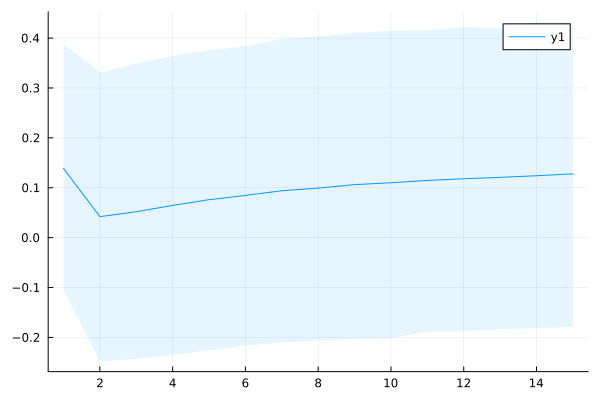

In [358]:
errorline(1:1:15,y,cenetertype=:median, errortype=:percentile, percentiles=[5,95], errorstyle=:ribbon)